In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
import eli5
import numpy as np
import xgboost as xgb
import warnings

shap.initjs()
warnings.filterwarnings('ignore')


/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data, labels = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in labels])
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [3]:
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,0,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,1,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,0,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [4]:
from sklearn.model_selection import train_test_split
# label encoded
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
# not encoded
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)

In [5]:
import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

{'_Booster': <xgboost.core.Booster at 0x10da9bdd8>,
 '_features_count': 12,
 '_le': LabelEncoder(),
 'base_score': 0.5,
 'booster': 'gbtree',
 'classes_': array([0, 1]),
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'kwargs': {},
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'n_classes_': 2,
 'n_estimators': 500,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [6]:
eli5.show_weights(xgc.get_booster())

Weight,Feature
0.3294,Relationship
0.1828,Marital Status
0.1281,Capital Gain
0.0985,Education-Num
0.0583,Capital Loss
0.0494,Sex
0.0368,Occupation
0.0327,Age
0.0301,Hours per week
0.0209,Workclass


In [7]:
predictions = xgc.predict(X_test)
doc_num = 2
print('Actual Label: ', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns), 
                     show_feature_values=True)

Actual Label:  1
Predicted Label: 1


In [8]:
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgc).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=X_train.columns.tolist())

Weight,Feature
0.0541 ± 0.0008,Capital Gain
0.0385 ± 0.0019,Education-Num
0.0349 ± 0.0026,Age
0.0305 ± 0.0014,Occupation
0.0281 ± 0.0016,Relationship
0.0189 ± 0.0016,Hours per week
0.0168 ± 0.0011,Marital Status
0.0166 ± 0.0014,Capital Loss
0.0110 ± 0.0017,Workclass
0.0052 ± 0.0004,Country


In [34]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)
print('Expected Value:', explainer.expected_value)

Expected Value: -1.3625857


In [35]:
shap_values.shape

(9769, 12)

In [10]:
shap.force_plot(explainer.expected_value, 
                shap_values[2,:], X_test_disp.iloc[2,:])

In [11]:
shap.force_plot(explainer.expected_value, 
                shap_values[:1000,:], X_test_disp.iloc[:1000,:])

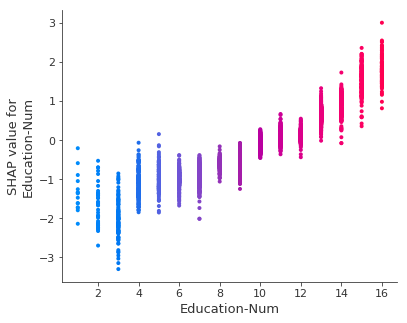

In [13]:
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

In [16]:
shap_inter = explainer.shap_interaction_values(X_test)

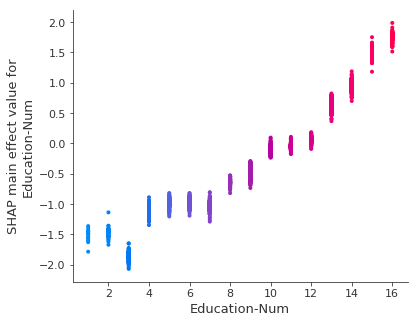

In [31]:
shap.dependence_plot(('Education-Num', 'Education-Num'), shap_inter, features=X_test)